In [ ]:
import sys
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import timm

In [2]:
import torch
device=torch.device("cpu")
if torch.cuda.is_available():
    device=torch.device("cuda")
elif torch.backends.mps.is_available():
    device=torch.device("mps")

In [3]:
device

device(type='cuda')

In [25]:
import timm
Eff_Net_model = timm.create_model('tf_efficientnetv2_xl.in21k_ft_in1k', pretrained=True) #,num_classes=10)
Eff_Net_model = Eff_Net_model.eval()

In [109]:
# Get model-specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(Eff_Net_model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [ ]:
#Allow loading truncated images (with caveats):
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#This lets PIL load some truncated files, 
# but pixels beyond the truncation 
# may be zeros or artifacts

In [ ]:
# images in folder "D:\msc_dwm_lab_2024\olympics"
dataset=torchvision.datasets.ImageFolder(
    root="./olympics",
    transform=transforms
    )

In [68]:
print(dataset.class_to_idx)
print(dataset[0])

{'athletics': 0, 'badminton': 1, 'basketball': 2, 'football': 3, 'handball': 4, 'rugby': 5, 'swimming': 6, 'tennis': 7, 'waterpolo': 8, 'weightlifting': 9}
(tensor([[[-0.8196, -0.1451,  0.0510,  ...,  0.0196,  0.0039, -0.2706],
         [-0.8039, -0.1843,  0.0039,  ...,  0.0745,  0.1529, -0.1137],
         [-0.8118, -0.2392, -0.0667,  ...,  0.5529,  0.6863,  0.3176],
         ...,
         [-0.8118,  0.0824,  0.3412,  ...,  0.3569,  0.3882,  0.0275],
         [-0.8588, -0.0510,  0.2549,  ...,  0.2000,  0.2235, -0.0902],
         [-0.9451, -0.5922, -0.4745,  ..., -0.5373, -0.5294, -0.6549]],

        [[-0.8980, -0.2314, -0.0431,  ..., -0.0588, -0.0667, -0.3333],
         [-0.8902, -0.2706, -0.0902,  ..., -0.0118,  0.0745, -0.1843],
         [-0.8902, -0.3176, -0.1608,  ...,  0.4588,  0.5922,  0.2471],
         ...,
         [-0.9059, -0.2706, -0.0667,  ..., -0.0196,  0.0039, -0.2471],
         [-0.9137, -0.3490, -0.1137,  ..., -0.1294, -0.1059, -0.3412],
         [-0.9686, -0.8118, -0.7

In [ ]:
#identifies corrupt files so they can be deleted or regenerated
from PIL import Image
bad = []
for p, _ in dataset.samples:
    try:
        with Image.open(p) as im:
            im.verify()  # verify file integrity
    except Exception as e:
        bad.append(p)
print(f"{len(bad)} bad images")
# Optionally remove from dataset.samples:
dataset.samples = [(p,t) for (p,t) in dataset.samples if p not in bad]
dataset.imgs = dataset.samples

5 bad images


In [ ]:
from torch.utils.data import random_split
train_ds,val_ds=random_split(dataset,[0.8,0.2])

In [71]:
len(train_ds)

795

In [72]:
len(val_ds)

198

In [ ]:
train_data_loader=DataLoader(train_ds,batch_size=4,shuffle=True)
test_data_loader=DataLoader(val_ds,batch_size=4,shuffle=False)
#check if data has correct shape [batch, channels, height, width] 
for X,y in train_data_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([4, 3, 384, 384])
torch.Size([4])


In [110]:
out=Eff_Net_model(X)

In [111]:
out.shape

torch.Size([4, 1280])

In [76]:
'''
(conv_head): Conv2d(640, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNormAct2d(
    1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (classifier): Linear(in_features=1280, out_features=1000, bias=True)
  (fc): Identity()
  )
'''
#updating EfficientNet for the underlying task 
#Eff_Net_model.fc=nn.Identity() #didn't work as not part of timm
# remove classifier, keep pooling
from torch import nn
Eff_Net_model.reset_classifier(num_classes=0)  
# classifier -> Identity
# shape [B, 1280]

for param in Eff_Net_model.parameters():
    param.requires_grad=False 
    #no tracking of gradients 
#for speedup processing while training of model
Eff_Net_model=Eff_Net_model.to(device)
Eff_Net_model.eval() 
#on purpose as we don't want to re-train Eff_net model

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

In [77]:
#check what's shape of output of model
for X,y in train_data_loader:
    print(Eff_Net_model(X.to(device)).shape)
    #print(y.shape)
    break 

torch.Size([4, 1280])


In [78]:
#Part2: define trainable part of model 
#check last layer output shape
#(classifier): Linear(in_features=1280, out_features=1000, bias=True)
fc_model=nn.Sequential(
    nn.Linear(1280, 824),
    nn.ReLU(),
    nn.Linear(824,10) 
    # output layer with 10 sigmoidal output
    #for 10 classes of Sport images of Olympics dataset
)
fc_model=fc_model.to(device)

In [79]:
#Model ready for Transfer learning
model=nn.Sequential(
    Eff_Net_model,
    fc_model
)

In [80]:
#check what's shape of output of model 
for X,y in train_data_loader:
    print(model(X.to(device))) #shape[4,10]
    #send one batch to GPU
    y=y.to(device).type(torch.long) 
    break 
print(y) #shape [4,1]
#print(X.shape)
#print(y.dtype)

tensor([[-0.4025,  0.1565, -0.1483,  0.1466,  0.0794, -0.0934,  0.1447,  0.0898,
         -0.1222,  0.1551],
        [-0.1179,  0.2135, -0.2331,  0.2093,  0.1995,  0.1210,  0.4267,  0.1934,
         -0.0809, -0.0240],
        [-0.1138, -0.0099, -0.0781,  0.1770,  0.3040,  0.1422,  0.0600,  0.2033,
          0.0158,  0.1759],
        [-0.0703,  0.0321,  0.0659, -0.0033,  0.3217, -0.2047,  0.0695,  0.1347,
          0.2371, -0.0973]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([3, 4, 9, 6], device='cuda:0')


In [81]:
optimizer=torch.optim.AdamW(fc_model.parameters(),lr=0.001)
#rem to pass only fine-tune model's parameter
loss_fn=nn.CrossEntropyLoss() 
#suitable for multiclass output

In [83]:
#Training steps
for epochs in range(5):
    model.train() # Puts full model in train mode
    Eff_Net_model.eval() #Puts ResNet part in eval() mode
    loss_sum=0
    train_acc_sum=0 
    train_count=0
    for X,y in train_data_loader:
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.long) 
        outputs=model(X)
        #print(outputs)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        loss_sum=loss_sum+loss.item()
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1) 
        acc = (preds == y).sum().item()
        train_acc_sum=train_acc_sum+acc
        train_count=train_count+y.size(0)
    print("Train loss:",loss_sum/len(train_data_loader))
    print("Train Acc:",train_acc_sum/train_count)
    break #remove it for training more than one batch/epoch
    

Train loss: 0.08696176913804837
Train Acc: 0.9672955974842767


In [86]:
#Performance on Test data 
model.eval()
test_loss_sum=0
test_acc_sum=0
test_count=0
with torch.no_grad():
    for X,y in test_data_loader:
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.long) 
        outputs=model(X)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        test_loss_sum=test_loss_sum+loss.item()
        preds = outputs.argmax(dim=1) 
        acc = (preds == y).sum().item()
        test_acc_sum=test_acc_sum+acc
        test_count=test_count+y.size(0)
        break
    print("Test loss:",test_loss_sum/len(test_data_loader))
    print("Test Acc total:",test_acc_sum)
    print("Test Acc:",test_acc_sum/test_count)

Test loss: 0.0014531393349170685
Test Acc total: 4
Test Acc: 1.0


Using tqdm for showing progress bar of training/evaluation 

In [87]:
from tqdm import tqdm

In [89]:
for epoch in range(5):
    print(f"--------------epoch: {epoch}---------- ")
    model.train() # Puts full model in train mode
    Eff_Net_model.eval() #Puts ResNet part in eval() mode
    loss_sum=0
    train_acc_sum=0 
    train_count=0
    for X,y in tqdm(train_data_loader):
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.long) 
        outputs=model(X)
        #print(outputs)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        loss_sum=loss_sum+loss.item()
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1) 
        acc = (preds == y).sum().item()
        train_acc_sum=train_acc_sum+acc
        train_count=train_count+y.size(0)
    print("Train loss:",loss_sum/len(train_data_loader))
    print("Train Acc:",train_acc_sum/train_count)
    torch.save(fc_model.state_dict(),f"fc_model_{epoch}.pth")
    break #remove it for training more than one batch/epoch

--------------epoch: 0---------- 


100%|██████████| 199/199 [00:14<00:00, 13.44it/s]

Train loss: 0.04073914245737573
Train Acc: 0.9911949685534591


In [90]:
#Performance on Test data with tqdm
model.eval()
test_loss_sum=0
test_acc_sum=0
test_count=0
with torch.no_grad():
    for X,y in tqdm(test_data_loader):
        X=X.to(device) #send one batch to GPU
        y=y.to(device).type(torch.long) 
        outputs=model(X)
        optimizer.zero_grad()
        loss=loss_fn(outputs, y)
        test_loss_sum=test_loss_sum+loss.item()
        preds = outputs.argmax(dim=1) 
        acc = (preds == y).sum().item()
        test_acc_sum=test_acc_sum+acc
        test_count=test_count+y.size(0)
        break
    print("Test loss:",test_loss_sum/len(test_data_loader))
    print("Test Acc total:",test_acc_sum)
    print("Test Acc:",test_acc_sum/test_count)

  0%|          | 0/50 [00:00<?, ?it/s]

Test loss: 0.0003893023356795311
Test Acc total: 4
Test Acc: 1.0


In [ ]:
#Data check
from PIL import Image
image=Image.open(".\olympics\\basketball\\basketball11.png")

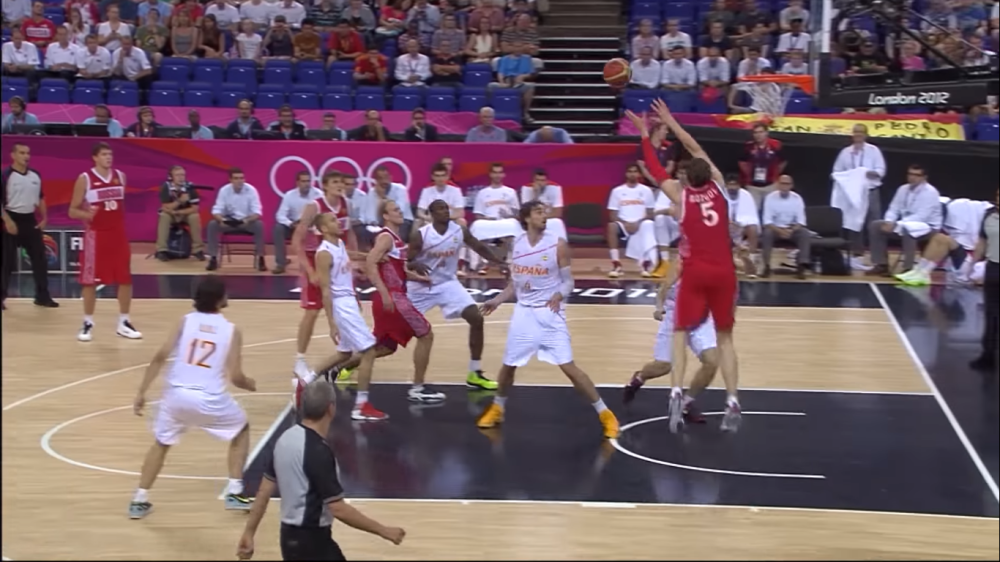

In [97]:
image

In [98]:
image.size

(1000, 562)

In [107]:
#pre-processing pipeline for data augmentation
from torchvision import transforms
preprocess2 = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.1,hue=0.1),
    transforms.Resize(400),
    transforms.CenterCrop(384),
])

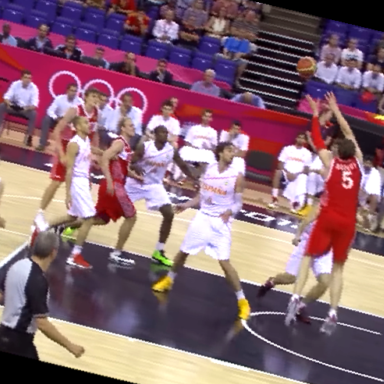

In [108]:
preprocess2(image)